In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim, mu0, sigma0, fixed):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid, mu0, sigma0, scale=False)
        self.fixed = fixed
        if self.fixed:
            self.embeddings = GraphConvolution(batch_size, nhid, 2*ndim, mu0, sigma0, scale=True)
        else:
            self.embeddings = GraphConvolution(batch_size, nhid, 4 * ndim, mu0, sigma0, scale=True)
        self.reconstructions = InnerProduct(2*ndim)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.embeddings(x, adj)
        x = norm_embed(x)
        if self.fixed:
            mu = F.relu(self.reconstructions(x))
            return mu
        else:
            lr1, lr2 = torch.chunk(x, chunks=2, dim=2)
            mu = F.relu(self.reconstructions(lr1))
            sigma = F.relu(self.reconstructions(lr2))
            return mu, sigma
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=10000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.0001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-2,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [7]:
def svdApprox(adj,dim,relu=False):
    adj = torch.FloatTensor(adj[0])
    U, S, Vh = torch.linalg.svd(adj)
    mu = torch.matmul(torch.matmul(U[:, :dim], torch.diag(S[:dim])), Vh[:dim, :])
    
    embedx = torch.matmul(U[:, :dim],torch.diag(torch.pow(S[:dim], 0.5)))
    embedy = torch.transpose(torch.matmul(torch.diag(torch.pow(S[:dim], 0.5)),Vh[:dim, :]),0,1)
    
    criterion = torch.nn.GaussianNLLLoss()
    if relu:
        crt = torch.nn.ReLU()
        mu = crt(mu)
    mse = torch.nn.MSELoss()
    mseloss = mse(torch.flatten(mu), torch.flatten(adj))
    sig = torch.sqrt(mseloss)
    sigma = sig * torch.ones(adj.shape)
    loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma)))
    
    return mu,loss.item(),embedx,embedy

In [8]:
def GraphNeuralNet(adj,dim,fixed=False):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    
    # loss function
    criterion = torch.nn.GaussianNLLLoss()
    
    
    #features = torch.FloatTensor(torch.eye(adj.shape[1]))
    #features = features.reshape((1,adj.shape[1],adj.shape[1]))
    #features = features.repeat(adj.shape[0], 1, 1)
    
    #svd features
    svd_mu,svd_loss,svdembedx,svdembedy = svdApprox(adj=adj,dim=dim)
    features = torch.cat((svdembedx,svdembedy),dim=1)
    features = features.unsqueeze(dim=0)

    # Model and optimizer
    model = GNN(batch_size=adj.shape[0],
                nfeat=features.shape[2],
                nhid=args.hidden*args.ndim,
                ndim=args.ndim,
                mu0=adj.mean(),
                sigma0=adj.std(),
                fixed=fixed)

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))
    

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:])
    sigma0 = adj.std()*torch.ones(adj.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))

    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        
        if fixed:
            mu = model(features, adj_norm)
            with torch.no_grad():
                mse = torch.nn.MSELoss()
                mseloss = mse(torch.flatten(mu),torch.flatten(adj))
                sig = torch.sqrt(mseloss)
            sigma = sig * torch.ones(adj.shape,requires_grad=True)
        else:
            mu,sigma = model(features, adj_norm)
        
        loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma))) 
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
        else:
            if loss < best_loss:
                best_loss = loss

        if epoch % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return mu,best_loss.item(),loss0


In [9]:
fix_loss = []
nonfix_loss = []
svd_loss = []
svdrelu_loss = []
nmi_fix = []
nmi_nonfix = []
nmi_svd = []
nmi_svdrelu = []
dims = [x for x in range(1,15)]
for dim in dims:
    mu,loss,loss0 = GraphNeuralNet(adj=adj,dim=dim,fixed=True)
    fix_loss.append(loss)
    nmi_fix.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,loss,loss0 = GraphNeuralNet(adj=adj,dim=dim)
    nonfix_loss.append(loss)
    nmi_nonfix.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,loss,embedx,embedy = svdApprox(adj=adj,dim=dim)
    svd_loss.append(loss)
    nmi_svd.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,loss,embedx,embedy = svdApprox(adj=adj,dim=dim,relu=True)
    svdrelu_loss.append(loss)
    nmi_svdrelu.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))

Epoch: 0001 loss: 23.64076614 time: 0.0080s
Epoch: 1001 loss: 18.99718857 time: 0.0040s
Epoch: 2001 loss: 11.05740929 time: 0.0030s
Epoch: 3001 loss: 11.05740929 time: 0.0030s
Epoch: 4001 loss: 11.05740929 time: 0.0030s
Epoch: 5001 loss: 11.05740929 time: 0.0020s
Epoch: 6001 loss: 11.05740929 time: 0.0030s
Epoch: 7001 loss: 11.05740929 time: 0.0030s
Epoch: 8001 loss: 11.05740929 time: 0.0030s
Epoch: 9001 loss: 11.05740929 time: 0.0030s
Optimization Finished!
Total time elapsed: 29.0577s
Epoch: 0001 loss: 21.03638268 time: 0.0030s
Epoch: 1001 loss: 16.39398384 time: 0.0030s
Epoch: 2001 loss: 9.06824684 time: 0.0020s
Epoch: 3001 loss: 9.06823635 time: 0.0030s
Epoch: 4001 loss: 9.06817436 time: 0.0030s
Epoch: 5001 loss: 9.06812859 time: 0.0030s
Epoch: 6001 loss: 9.06812859 time: 0.0030s
Epoch: 7001 loss: 9.06812859 time: 0.0030s
Epoch: 8001 loss: 9.06812859 time: 0.0030s
Epoch: 9001 loss: 9.06812763 time: 0.0020s
Optimization Finished!
Total time elapsed: 27.8522s
Epoch: 0001 loss: 24.108

Epoch: 9001 loss: 10.97842598 time: 0.0020s
Optimization Finished!
Total time elapsed: 27.9471s
Epoch: 0001 loss: 23.66622734 time: 0.0030s
Epoch: 1001 loss: 9.27201366 time: 0.0030s
Epoch: 2001 loss: 8.82846451 time: 0.0030s
Epoch: 3001 loss: 8.80338001 time: 0.0020s
Epoch: 4001 loss: 8.74982548 time: 0.0020s
Epoch: 5001 loss: 8.68332481 time: 0.0030s
Epoch: 6001 loss: 8.62209129 time: 0.0030s
Epoch: 7001 loss: 8.54209042 time: 0.0030s
Epoch: 8001 loss: 8.43081570 time: 0.0030s
Epoch: 9001 loss: 8.13914299 time: 0.0030s
Optimization Finished!
Total time elapsed: 26.6315s
Epoch: 0001 loss: 26.25801468 time: 0.0030s
Epoch: 1001 loss: 10.97857952 time: 0.0030s
Epoch: 2001 loss: 10.97807789 time: 0.0020s
Epoch: 3001 loss: 10.97790241 time: 0.0020s
Epoch: 4001 loss: 10.97758961 time: 0.0020s
Epoch: 5001 loss: 10.97742653 time: 0.0030s
Epoch: 6001 loss: 10.97734261 time: 0.0030s
Epoch: 7001 loss: 10.97726631 time: 0.0030s
Epoch: 8001 loss: 10.97719669 time: 0.0020s
Epoch: 9001 loss: 10.9771

NMI Score
Dim	 Nonfix	 Fix	 SVDRel	 SVD
1	 0.3915	 0.0000	 0.2876	 0.2825
2	 0.0347	 0.0000	 0.1398	 0.1398
3	 0.1472	 0.3685	 0.5415	 0.5641
4	 0.4233	 0.3577	 0.5796	 0.5915
5	 0.3811	 0.3330	 0.4507	 0.4626
6	 0.3705	 0.3330	 0.4768	 0.4725
7	 0.3538	 0.3258	 0.4769	 0.4769
8	 0.3559	 0.3252	 0.8498	 0.8498
9	 0.3813	 0.3349	 0.8584	 0.6455
10	 0.3857	 0.3188	 0.6778	 0.8232
11	 0.3996	 0.3347	 0.5178	 0.5178
12	 0.3567	 0.3238	 0.7023	 0.7089
13	 0.4011	 0.3188	 0.7023	 0.7023
14	 0.3868	 0.3173	 0.7023	 0.7023

 NLL0 = 11.34196949005127


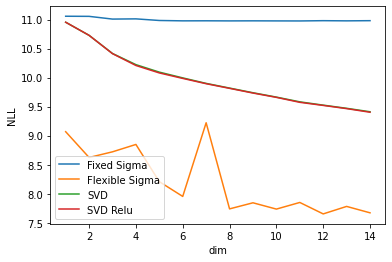

In [10]:
plt.plot(dims,fix_loss,label="Fixed Sigma")
plt.plot(dims,nonfix_loss,label="Flexible Sigma")
plt.plot(dims,svd_loss,label="SVD")
plt.plot(dims,svdrelu_loss,label="SVD Relu")
plt.xlabel("dim")
plt.ylabel("NLL")
plt.legend()
print("NMI Score")
print("{}\t {}\t {}\t {}\t {}".format("Dim","Nonfix","Fix","SVDRel","SVD"))
for i in dims:
    print("{}\t {:.4f}\t {:.4f}\t {:.4f}\t {:.4f}".format(i,nmi_nonfix[i-1],nmi_fix[i-1],nmi_svdrelu[i-1],nmi_svd[i-1]))
print("\n NLL0 = {}".format(loss0))